In [34]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load training data

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

valset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## P3.1

In [35]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x



In [36]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3):
        super(InceptionModule, self).__init__()
        self.branch1x1 = ConvModule(in_channels, ch1x1, kernel_size=1)
        self.branch3x3 = ConvModule(in_channels, ch3x3, kernel_size=3, padding=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        outputs = torch.cat([branch1x1, branch3x3], dim=1)  # Concatenate along channel dimension
        return outputs


In [37]:
class DownsampleModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownsampleModule, self).__init__()
        self.branch_conv = ConvModule(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.branch_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        branch_conv = self.branch_conv(x)
        branch_pool = self.branch_pool(x)
        outputs = torch.cat([branch_conv, branch_pool], dim=1)  # Concatenate along channel dimension
        return outputs


In [38]:
class SmallInception(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallInception, self).__init__()
        self.conv1 = ConvModule(in_channels=1, out_channels=96, kernel_size=3, stride=1, padding=1)

        # First block of Inception and Downsample modules
        self.inception1 = InceptionModule(96, 32, 32)
        self.inception2 = InceptionModule(64, 32, 48)
        self.downsample1 = DownsampleModule(80, 80)

        # Second block of Inception and Downsample modules
        self.inception3 = InceptionModule(160, 112, 48)
        self.inception4 = InceptionModule(160, 96, 64)
        self.inception5 = InceptionModule(160, 80, 80)
        self.inception6 = InceptionModule(160, 48, 96)
        self.downsample2 = DownsampleModule(144, 96)

        # Third block of Inception modules
        self.inception7 = InceptionModule(240, 176, 160)
        self.inception8 = InceptionModule(336, 176, 160)

        # Final layers: Global average pooling and fully connected layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(336, num_classes)

    def forward(self, x):
        x = self.conv1(x)

        # First block
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.downsample1(x)

        # Second block
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.downsample2(x)

        # Third block
        x = self.inception7(x)
        x = self.inception8(x)

        # Global pooling and fully connected
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)

        return x

model = SmallInception(num_classes=10).to(device)


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

lrmin = 1e-9  # Minimum learning rate
lrmax = 10  # Maximum learning rate
num_epochs = 5

model = SmallInception(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lrmin)

total_steps = num_epochs * len(trainloader)

def linear_lr(step):
    return lrmin + step * (lrmax - lrmin) / (total_steps - 1)

lr_rates = []
train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for step, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_step = epoch * len(trainloader) + step
        new_lr = linear_lr(current_step)
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr

        lr_rates.append(new_lr)
        running_loss += loss.item()
        train_losses.append(loss.item())

    print(f"Epoch {epoch + 1}, Average Loss: {running_loss / len(trainloader):.4f}")

print('Finished Training')




Epoch 1, Average Loss: 0.6209
Epoch 2, Average Loss: 0.3258
Epoch 3, Average Loss: 0.2800
Epoch 4, Average Loss: 0.2582
Epoch 5, Average Loss: 0.2431
Finished Training


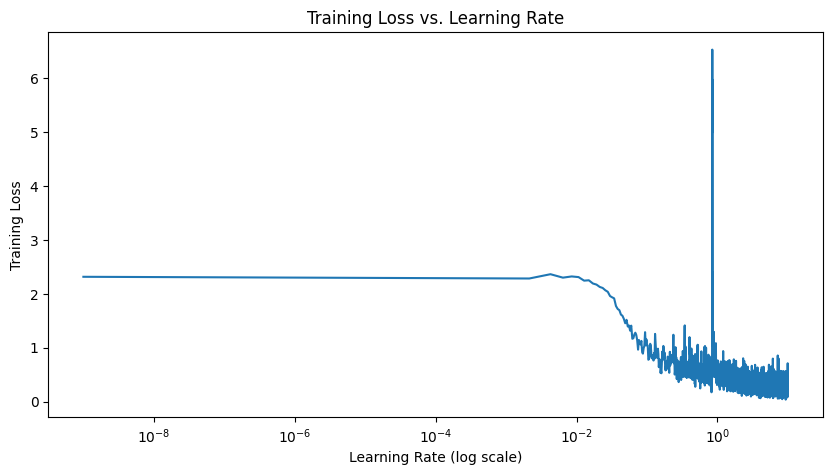

In [40]:
# Plot the learning rate against training loss
plt.figure(figsize=(10, 5))
plt.plot(lr_rates, train_losses)
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Learning Rate')
plt.show()

## P3.2


Epoch [1/10] - Train Loss: 0.4939, Train Acc: 88.90%, Val Loss: 0.3297, Val Acc: 87.70%
Epoch [2/10] - Train Loss: 0.2649, Train Acc: 89.77%, Val Loss: 0.3568, Val Acc: 88.64%
Epoch [3/10] - Train Loss: 0.2168, Train Acc: 93.55%, Val Loss: 0.2244, Val Acc: 91.71%
Epoch [4/10] - Train Loss: 0.1680, Train Acc: 95.03%, Val Loss: 0.2096, Val Acc: 92.46%
Epoch [5/10] - Train Loss: 0.1158, Train Acc: 97.61%, Val Loss: 0.1703, Val Acc: 93.96%
Epoch [6/10] - Train Loss: 0.0930, Train Acc: 96.13%, Val Loss: 0.2276, Val Acc: 92.60%
Epoch [7/10] - Train Loss: 0.1271, Train Acc: 95.38%, Val Loss: 0.2251, Val Acc: 92.08%
Epoch [8/10] - Train Loss: 0.1281, Train Acc: 94.98%, Val Loss: 0.2557, Val Acc: 91.72%
Epoch [9/10] - Train Loss: 0.0888, Train Acc: 98.17%, Val Loss: 0.2049, Val Acc: 93.29%
Epoch [10/10] - Train Loss: 0.0394, Train Acc: 99.70%, Val Loss: 0.2034, Val Acc: 93.80%
Finished Training


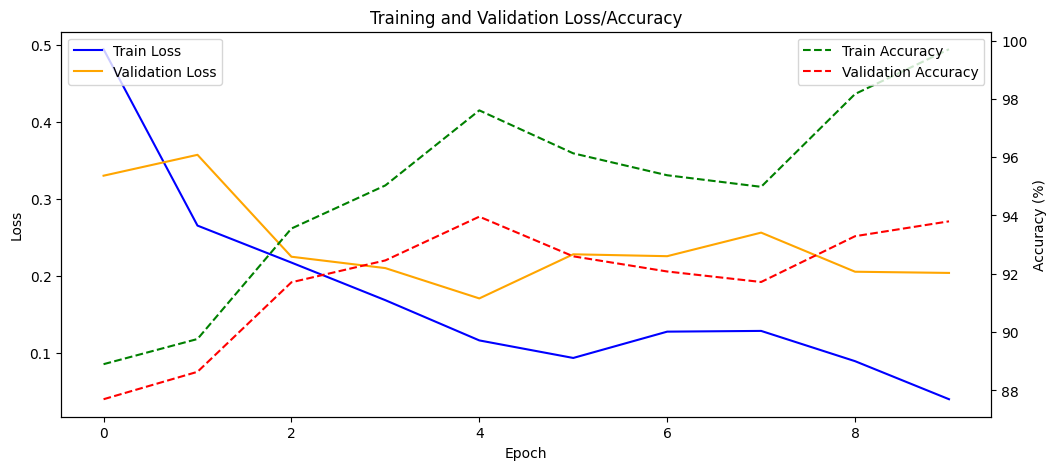

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set lrmin lrmax
lrmin = 1e-3
lrmax = 1e-1
num_epochs = 10
batch_size = 64

model = SmallInception(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lrmin)

# Define the Cyclical Learning Rate Scheduler with exponential decay
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=lrmin,
    max_lr=lrmax,
    step_size_up=5 * len(trainloader) // 2,
    mode='exp_range',
    gamma=0.99994
)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lr_rates = []

def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        lr_rates.append(optimizer.param_groups[0]['lr'])
        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Calculate traiing accuracy
    train_acc = calculate_accuracy(trainloader, model)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(valloader)
    val_losses.append(avg_val_loss)
    val_acc = calculate_accuracy(valloader, model)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print('Finished Training')

In [ ]:
# Plot train/validation loss and accuracy curves
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot loss curves
ax1.plot(np.arange(len(train_losses)), train_losses, label='Train Loss', color='blue')
ax1.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# Plot accuracy curves on the same figure but different y-axis
ax2 = ax1.twinx()
ax2.plot(np.arange(len(train_accuracies)), train_accuracies, label='Train Accuracy', color='green', linestyle='--')
ax2.plot(np.arange(len(val_accuracies)), val_accuracies, label='Validation Accuracy', color='red', linestyle='--')
ax2.set_ylabel('Accuracy (%)')
ax2.legend(loc='upper right')

plt.title('Training and Validation Loss/Accuracy')
plt.show()

## P3.3

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

# Hyperparameters
lrmax = 1e-1  # Use the lrmax identified earlier
initial_batch_size = 32  # Starting batch size
max_batch_size = 8192  # Maximum batch size to reach
step_size = 500  # Number of steps before doubling the batch size
running_loss = 0.0

# Transformation for FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training set without defining DataLoader yet
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Initialize model, optimizer, and loss function
model = SmallInception(num_classes=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=lrmax)
criterion = nn.CrossEntropyLoss()

# Lists to store training losses and corresponding batch sizes
train_losses = []
batch_sizes_tracked = []

# Initialize the starting batch size
current_batch_size = initial_batch_size

# Initialize DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=current_batch_size, shuffle=True)

# Track the number of steps
current_step = 0

while current_batch_size <= max_batch_size:
    print(f"Training with batch size: {current_batch_size}")

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        current_step += 1

        # double the step size by 2 every step size has been itered.
        if current_step % step_size == 0:
            avg_loss = running_loss / step_size
            train_losses.append(avg_loss)
            batch_sizes_tracked.append(current_batch_size)

            print(f"Step {current_step}, Batch size: {current_batch_size}, Average Training Loss: {avg_loss:.4f}")

            current_batch_size *= 2

            running_loss = 0.0

            # Reinitialize DataLoader with the new batch size
            if current_batch_size <= max_batch_size:
                trainloader = torch.utils.data.DataLoader(trainset, batch_size=current_batch_size, shuffle=True)

            break

    if current_batch_size > max_batch_size:
        break

print('Finished Training')

Training with batch size: 32
Step 500, Batch size: 32, Average Training Loss: 0.6081
Training with batch size: 64
Step 1000, Batch size: 64, Average Training Loss: 0.2976
Training with batch size: 128
Training with batch size: 128
Step 1500, Batch size: 128, Average Training Loss: 0.2148
Training with batch size: 256
Training with batch size: 256
Training with batch size: 256
Step 2000, Batch size: 256, Average Training Loss: 0.1487
Training with batch size: 512
Training with batch size: 512
Training with batch size: 512
Training with batch size: 512
Training with batch size: 512
Step 2500, Batch size: 512, Average Training Loss: 0.0751
Training with batch size: 1024
Training with batch size: 1024
Training with batch size: 1024
Training with batch size: 1024
Training with batch size: 1024
Training with batch size: 1024
Training with batch size: 1024
Training with batch size: 1024
Training with batch size: 1024
Step 3000, Batch size: 1024, Average Training Loss: 0.0102
Training with bat

OutOfMemoryError: CUDA out of memory. Tried to allocate 294.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 223.06 MiB is free. Process 5797 has 14.53 GiB memory in use. Of the allocated memory 13.85 GiB is allocated by PyTorch, and 553.93 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

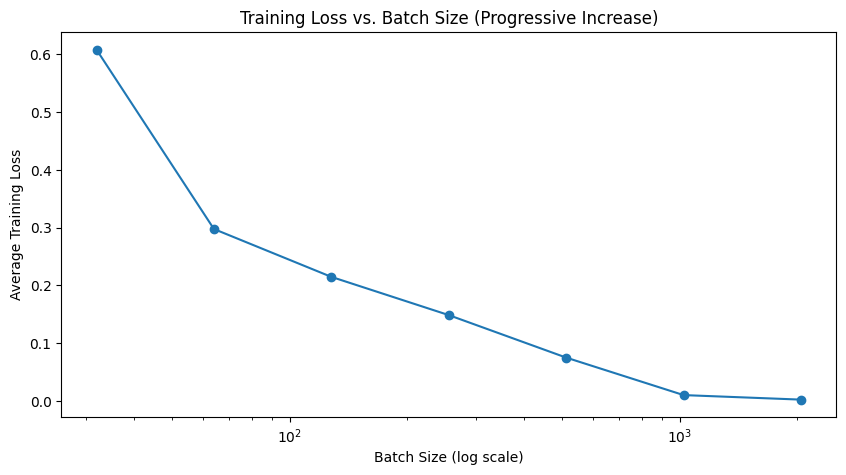

In [47]:

plt.figure(figsize=(10, 5))
plt.plot(batch_sizes_tracked, train_losses, marker='o')
plt.xscale('log')
plt.xlabel('Batch Size (log scale)')
plt.ylabel('Average Training Loss')
plt.title('Training Loss vs. Batch Size (Progressive Increase)')
plt.show()
